This Jupyter notebook demonstrates how the Gliquid binary fitting code works, and how it can be used to fit the liquid non-ideal mixing parameters for a user-input system

In [1]:
import os
from gliquid.binary import BinaryLiquid, BLPlotter
from gliquid.config import data_dir
import gliquid.load_binary_data as lbd

# Set the environmental variables for Materials Project API keys.
os.environ["NEW_MP_API_KEY"] = "Rtb4ppAs9rcNVzh10IVdBRh6HwlBymcJ"
param_format = 'linear'   

Now that we have loaded in the required packages and set our API keys, lets look over some of the functionality
The `load_binary_data` script is used as a backend for loading in the data used for the liquid energy fitting algorithm
It can load in digitized experimental data or computed DFT phase data.

We include JSON files for all elemental data of a type, since those can be used for multiple binary systems.
For a digitized binary phase diagram, the data on MPDS is in the form of **svgpaths**, which are essentially collections
of shapes as defined by their boundaries. You can see an example [here](../data/Cu-Mg.json)

<img src="../figures/digitized_pd_anatomy.png" width="700" height="500">

In [2]:
print("All cached melting temperatures (K):", lbd.melt_temps) # File at ../data/fusion_temperatures.json
print("All cached melting enthalpies (J/mol):", lbd.melt_enthalpies) # File at ../data/fusion_enthalpies.json
print("All cached boiling temperatures (K):", lbd.boiling_temps) # File at ../data/vaporization_temperatures.json
print()

# Now, we load the Cu-Mg phase diagram JSON (../data/Cu-Mg.json) as well as lists of component data for Cu and Mg
# This step will always print the link to the MPDS entry when it is called so the phase diagram can be viewed
cu_mg_json, cu_mg_component_data, cu_mg_digitized_liquidus = lbd.load_mpds_data('Cu-Mg', verbose=True)

print("Cu-Mg component data (Elt: [Hmelt, Tmelt, Tvap]):", cu_mg_component_data)
print("Cu-Mg digitized liquidus ([X, T]):", cu_mg_digitized_liquidus)
print()

# The liquidus is parsed earlier since having a complete liquidus curve is vital for data selection. 
# Once we have identified a good phase diagram source, we also need to know the solid phases decomposition behavior
identified_cu_mg_phases = lbd.identify_mpds_phases(cu_mg_json)

# 'type'=='lc' refers to line compounds (no solid solubility) and 'type'=='ss' refers to solid solution phases
print("Cu-Mg digitized solid phases:")
for phase in identified_cu_mg_phases:
    print(phase)

All cached melting temperatures (K): {'Al': 933.5, 'Ag': 1234.93, 'Fe': 1811.0, 'Ti': 1943.0, 'Ni': 1728.0, 'Cr': 2180.0, 'Cu': 1357.77, 'Zr': 2127.0, 'Nb': 2750.0, 'Zn': 692.7, 'Sn': 505.1, 'Si': 1687.0, 'Ca': 1115.0, 'Na': 370.9, 'Mg': 923.0, 'K': 336.7, 'Mn': 1519.0, 'Ba': 1000.0, 'Sr': 1050.0, 'V': 2183.0, 'Rb': 312.45, 'Ce': 1071.0, 'Nd': 1294.0, 'La': 1193.0, 'Y': 1795.0, 'Co': 1768.0, 'Sc': 1814.0, 'Li': 453.65, 'Ga': 302.9, 'Pb': 600.7, 'B': 2350.0, 'Th': 2023.0, 'Pr': 1204.0, 'Sm': 1347.0, 'Gd': 1586.0, 'Dy': 1685.0, 'Er': 1802.0, 'Yb': 1092.0, 'Hf': 2506.0, 'Cs': 301.7, 'Be': 1560.0, 'U': 1408.0, 'Ta': 3290.0, 'Eu': 1095.0, 'As': 1090.0, 'Ge': 1211.4, 'W': 3687.0, 'Ho': 1747.0, 'Mo': 2895.0, 'Tb': 1629.0, 'Tl': 577.0, 'Lu': 1936.0, 'Tm': 1818.0, 'In': 429.75, 'Sb': 903.778, 'Cd': 594.219, 'Hg': 234.321, 'Se': 494.0, 'Pd': 1828.0, 'Bi': 544.556, 'Pt': 2041.4, 'Au': 1337.33, 'Os': 3306.0, 'Te': 722.66, 'Ru': 2606.0, 'Ir': 2719.0, 'Rh': 2236.0, 'Re': 3458.0, 'Pu': 913.0, 'Pm': 1

Next, we'll walk through how to get DFT-calculated phase data with the `load_binary_data` script

In [3]:
cu_mg_dft_ch, _ = lbd.get_dft_convexhull('Cu-Mg', verbose=True) # This returns and caches a pymatgen PhaseDiagram object

# We can visualize this PhaseDiagram (convex hull of DFT T=0K compounds) using pymatgen's PDPlotter library
from pymatgen.analysis.phase_diagram import PDPlotter
cu_mg_pdp = PDPlotter(cu_mg_dft_ch)
fig = cu_mg_pdp.get_plot()
fig.update_layout(plot_bgcolor="white", paper_bgcolor="white") # Set a white figure background its visible in dark mode
fig.show()

Using DFT entries solved with GGA/GGA+U functionals.
Loading cached DFT entry data.
2 stable line compound(s) on the DFT convex hull.


To compare the data from both sources, we create a `BinaryLiquid` object to store all of the information.
The `from_cache()` method auto-populates the object using the cached MPDS data and DFT-calculated data from the MP API

In the event the digitized equilibrium phase data you have is not in the MPDS format, you can manually initialize 
`BinaryLiquid` objects, which is demonstrated in `adjustment_demo.ipynb`

Cu: H_fusion = 13260.0 J/mol, T_fusion = 1357.77 K, T_vaporization = 2835.15 K
Mg: H_fusion = 8480.0 J/mol, T_fusion = 923.0 K, T_vaporization = 1363.15 K

Reading MPDS json from entry at https://mpds.io/entry/C906729...



c:\Users\AbrarRauf\miniconda3\envs\gliquid-env\lib\site-packages\gliquid\binary.py:1382: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



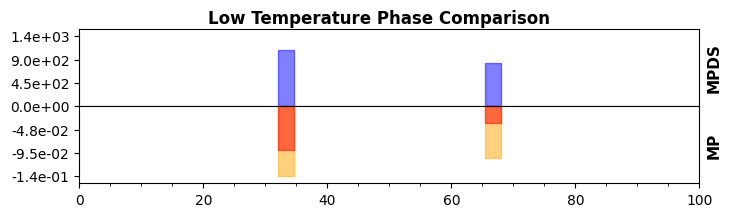

In [4]:
cu_mg_system = BinaryLiquid.from_cache('Cu-Mg', param_format=param_format)
cu_mg_plotter = BLPlotter(cu_mg_system)
cu_mg_plotter.show('pc') # Plot a 'phase comparison' figure to display how well the calculated & digitized phases match

# x-axis: Compostion of component B (Cu, atomic %)
# y-axis: Temperature (MPDS, Kelvin) and Energy (Materials Project, eV/atom)
# colors: Blue -> congruent melting phase, Purple -> incongruently melting phase, 
#         Yellow -> formation energy, Orange -> energy below convex hull

Now, we have enough information to fit the **DFT-referenced liquid free energy**. 

When `fit_parameters()` is called, the code will identify all invariant points using the liquidus and solid phase data
Only considering invariant points with matching DFT phases, the algorithm will narrow down the list of constraints and 
rank them in order of viability. The 'n_opts' parameter can be used to specify the maximum number of constraint 
combinations to try (default = 1).

Example invariant points on a phase diagram (left) and resulting constraints obtained from the points (right)

<img src="../figures/annotated_multi_invariant_points.png" width="900" height="700"> <img src="../figures/invariant_reactions.png" width="750" height="700">


--- Low temperature phases including component solid solutions ---
{'type': 'ss', 'name': '(Cu)', 'comp': 0.000381243, 'cbounds': [[0.000381243, 673.505], [0.0669068, 994.389]], 'tbounds': [[0.000381243, 673.505], [0.000381243, 1352.52]]}
{'type': 'lc', 'name': 'MgCu2', 'comp': 0.332825, 'tbounds': [[0.332825, 673.15], [0.332825, 1086.657]]}
{'type': 'lc', 'name': 'Mg2Cu', 'comp': 0.6666030000000001, 'tbounds': [[0.6666030000000001, 673.15], [0.6666030000000001, 838.482]]}
--- Identified invariant points ---
{'type': 'eut', 'comp': 0.22010100000000002, 'temp': 994.1469999999999, 'phases': ['(Cu)', 'MgCu2'], 'phase_comps': [0.000381243, 0.332825]}
{'type': 'cmp', 'comp': 0.332825, 'temp': 1086.657, 'phases': ['MgCu2'], 'phase_comps': [0.332825]}
{'type': 'eut', 'comp': 0.574707, 'temp': 822.939, 'phases': ['MgCu2', 'Mg2Cu'], 'phase_comps': [0.332825, 0.6666030000000001]}
{'type': 'cmp', 'comp': 0.6666030000000001, 'temp': 838.482, 'phases': ['Mg2Cu'], 'phase_comps': [0.6666030000000001]

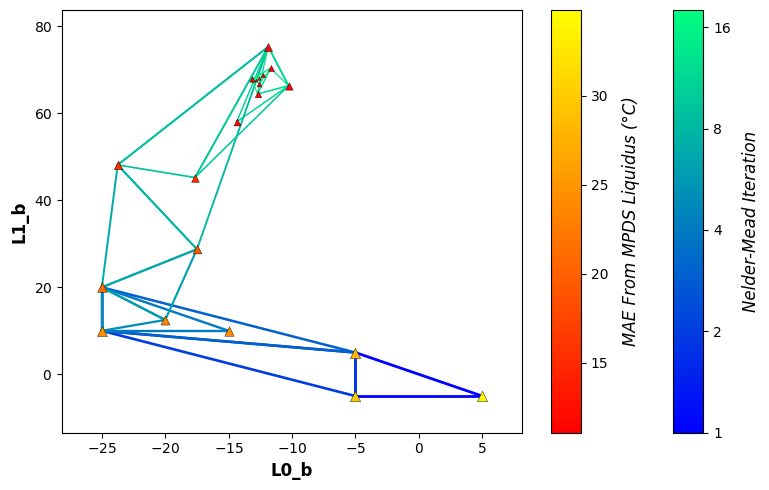

In [5]:
fit_results = cu_mg_system.fit_parameters(verbose=True, n_opts=3)[0]

print("--- Cu-Mg non-ideal mixing parameter fitting results: ---")
for field, value in fit_results.items():
    if isinstance(value, float):
        print(f'{field.upper()}: {value:.3f}')   

cu_mg_plotter.show('fit+liq')
cu_mg_plotter.show('nmp')

The Copper-Magnesium system is our 'model system' for testing this method. Let's see how it performs on other systems

In [6]:
import json
import numpy as np

other_systems_to_fit = ['C-Nb', 'Cr-Eu', 'B-Dy', 'Ag-V', 'Al-Cu']
cache_file = os.path.join(data_dir, f"fit_results_cache_{param_format}")

# If results are already cached, skip the fitting of the systems. If you wish to re-run the fitting, delete the cache
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        print("Loading fitting results from cache")
        fitting_results = json.load(f)
        for sys_results in fitting_results.values():
            sys_results['nmpath'] = np.array(sys_results.get('nmpath', []))
else:
    fitting_results = {}

    # Iterate through systems and fit non-ideal mixing parameters
    for sys_name in other_systems_to_fit:
        bl = BinaryLiquid.from_cache(sys_name, param_format=param_format)
        fitting_attempts_data = bl.fit_parameters(verbose=False, n_opts=5)
        best_fit_data = min(fitting_attempts_data, key=lambda x: x['mae'], default={})
        fitting_results[sys_name] = best_fit_data

    with open(cache_file, "w") as f:
        print("Saving fitting results to cache")
        for sys_results in fitting_results.values():
            sys_results['nmpath'] = sys_results.get('nmpath', np.array([])).tolist() # Numpy ndarray is not JSON serializable
        json.dump(fitting_results, f)

Retrieving ThermoDoc documents:   0%|          | 0/81 [00:00<?, ?it/s]

C: H_fusion = 0 J/mol, T_fusion = 0 K, T_vaporization = 5100.15 K
Nb: H_fusion = 30000.0 J/mol, T_fusion = 2750.0 K, T_vaporization = 5017.15 K

Reading MPDS json from entry at https://mpds.io/entry/C905339...

Maximum composition range fitted: [0.0187686, 0.999619]
Ignored composition ranges: []

Success: [['eut', '0.4 - 1st order', 3576.23, Eq(0.1969*a + 704.159687*b - 0.441845585*c - 1580.14143644455*d - 20920.4380663294, -96333.3092981563)], ['cmp', '0.55 - 0th order', 3887.4900000000002, Eq(0.247933884297521*a + 963.840495867769*b - 0.0225394440270473*c - 87.6218632607062*d - 29063.4060894031, -52545.441435358)], 597.229748847317]
Success: [['eut', '0.4 - 0th order rhs', 3576.23, Eq(0.274888953087511*a + 983.066120700151*b + 0.054125634862931*c + 193.56571916586*d - 27071.3875026955, -52545.441435358)], ['cmp', '0.55 - 0th order', 3887.4900000000002, Eq(0.247933884297521*a + 963.840495867769*b - 0.0225394440270473*c - 87.6218632607062*d - 29063.4060894031, -52545.441435358)], 842.

Retrieving ThermoDoc documents:   0%|          | 0/15 [00:00<?, ?it/s]

Cr: H_fusion = 21000.0 J/mol, T_fusion = 2180.0 K, T_vaporization = 2944.15 K
Eu: H_fusion = 9210.0 J/mol, T_fusion = 1095.0 K, T_vaporization = 1800.15 K

Reading MPDS json from entry at https://mpds.io/entry/C907707...

No phase data found in JSON!
Maximum composition range fitted: [0.0, 1.0]
Ignored composition ranges: []

Success: [['eut', '0.97 - 0th order lhs', 1064.027, Eq(0.000617195521448472*a + 0.656712699100254*b - 0.000586135774027101*c - 0.623664289230732*d - 8.70754092652817, 0.0)], ['eut', '0.97 - 1st order', 1064.027, Eq(-0.949676*a - 1010.480905252*b + 0.852826757464*c + 907.430696264147*d + 22007.4768929584, 0.0)], 11611.800943277292]
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 16.722137212753296 seconds ---
Mean temperature deviation per point between liquidus curves = 8.209803233008158 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 4.625972032546997 seconds ---
Mean temperature deviation per point between liquid

Retrieving ThermoDoc documents:   0%|          | 0/24 [00:00<?, ?it/s]

B: H_fusion = 50200.0 J/mol, T_fusion = 2350.0 K, T_vaporization = 4273.15 K
Dy: H_fusion = 11060.0 J/mol, T_fusion = 1685.0 K, T_vaporization = 2840.15 K

Reading MPDS json from entry at https://mpds.io/entry/C900285...

Maximum composition range fitted: [0.000381243, 0.9994280000000001]
Ignored composition ranges: [[0.00825169, 0.0200152]]

Liquidus continuity constraint violated for guess {b: 0, d: 0}
Failed: [['per', '0.01 - 0th order', 2298.11, Eq(0.00019354652641*a + 0.444791207808084*b + 0.000569869024709724*c + 1.30962170437567*d + 1149.25609363116, 0.0)], ['cmp', '0.2 - 0th order', 2772.64, Eq(0.16*a + 443.6224*b + 0.096*c + 266.17344*d - 19884.7539179057, -57546.7467623516)], inf]
Success: [['per', '0.4 - 0th order', 2372.87, Eq(0.226682681066667*a + 537.888533422661*b + 0.0773429362064214*c + 183.524733036131*d - 14358.5261957365, -54160.4826796972)], ['cmp', '0.2 - 0th order', 2772.64, Eq(0.16*a + 443.6224*b + 0.096*c + 266.17344*d - 19884.7539179057, -57546.7467623516)], 4

Retrieving ThermoDoc documents:   0%|          | 0/10 [00:00<?, ?it/s]

Ag: H_fusion = 11300.0 J/mol, T_fusion = 1234.93 K, T_vaporization = 2435.15 K
V: H_fusion = 21500.0 J/mol, T_fusion = 2183.0 K, T_vaporization = 3680.15 K

Reading MPDS json from entry at https://mpds.io/entry/C900067...

Maximum composition range fitted: [0.000381243, 0.999238]
Ignored composition ranges: []

Success: [['mig', '0.08-0.92 - 1st order', 2126.08, Eq(0.8450328*a + 1796.607335424*b + 0.57112064961376*c + 1214.24819073082*d - 35113.0054912686, -0.843608*a - 1793.57809664*b + 0.567511686496*c + 1206.57524642542*d + 52280.9753298599)], ['mig', '0.5 - 2nd order', 3141.62, Eq(-2*a - 6283.24*b + 0.0273719999999997*c + 85.9924226399989*d + 104479.889139154, 0)], 900.2856304940304]
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 22.234785795211792 seconds ---
Mean temperature deviation per point between liquidus curves = 20.909230546150457 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 6.324456453323364 seconds ---
Mean temperatu

Retrieving ThermoDoc documents:   0%|          | 0/33 [00:00<?, ?it/s]

Al: H_fusion = 10710.0 J/mol, T_fusion = 933.5 K, T_vaporization = 2792.15 K
Cu: H_fusion = 13260.0 J/mol, T_fusion = 1357.77 K, T_vaporization = 2835.15 K

Reading MPDS json from entry at https://mpds.io/entry/C903362...

Maximum composition range fitted: [0.000381243, 0.999619]
Ignored composition ranges: []

Success: [['eut', '0.17 - 1st order', 821.1519999999999, Eq(0.656068*a + 538.731550336*b + 0.145637830936*c + 119.590796148758*d - 6785.48033841955, -51542.1606046498)], ['per', '0.37 - 0th order', 895.502, Eq(0.268027627289*a + 240.019276292554*b + 0.00968206173284865*c + 8.67030564588943*d - 2959.40294306908, -20592.59556278)], 46.43508606430336]
Success: [['eut', '0.17 - 0th order rhs', 821.1519999999999, Eq(0.165371385664457*a + 135.79504408114*b + 0.108494874250109*c + 89.0907829802253*d - 1345.60541110215, -17180.7202015499)], ['per', '0.37 - 0th order', 895.502, Eq(0.268027627289*a + 240.019276292554*b + 0.00968206173284865*c + 8.67030564588943*d - 2959.40294306908, -2059

Once the systems are fit, display the results with the plotting code

C: H_fusion = 0 J/mol, T_fusion = 0 K, T_vaporization = 5100.15 K
Nb: H_fusion = 30000.0 J/mol, T_fusion = 2750.0 K, T_vaporization = 5017.15 K

Reading MPDS json from entry at https://mpds.io/entry/C905339...

Best fitted parameters for C-Nb: [81466.23, -42.39, 116623.4, 2.24]
MAE = 90.98
L0 = 81466 - 42.39*t
L1 = 2.24*t + 116623


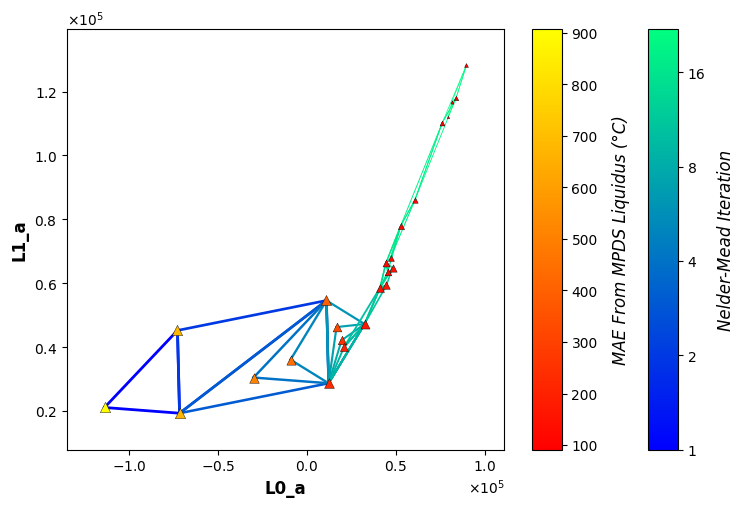

No arguments specified for 't_vals', setting 't_units' to 'K'


Cr: H_fusion = 21000.0 J/mol, T_fusion = 2180.0 K, T_vaporization = 2944.15 K
Eu: H_fusion = 9210.0 J/mol, T_fusion = 1095.0 K, T_vaporization = 1800.15 K

Reading MPDS json from entry at https://mpds.io/entry/C907707...

Best fitted parameters for Cr-Eu: [29909.42, -0.87, 7644.46, 0.54]
MAE = 8.16
L0 = 29909 - 0.87*t
L1 = 0.54*t + 7644


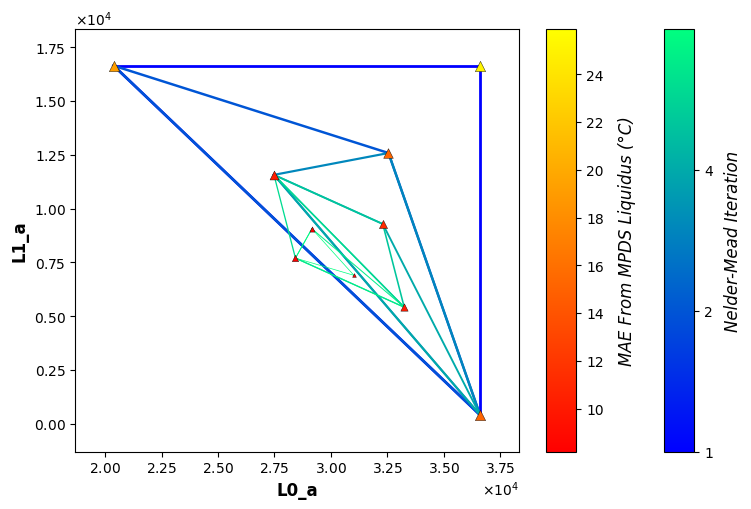

No arguments specified for 't_vals', setting 't_units' to 'K'


B: H_fusion = 50200.0 J/mol, T_fusion = 2350.0 K, T_vaporization = 4273.15 K
Dy: H_fusion = 11060.0 J/mol, T_fusion = 1685.0 K, T_vaporization = 2840.15 K

Reading MPDS json from entry at https://mpds.io/entry/C900285...

Best fitted parameters for B-Dy: [52512.32, -78.73, 66933.72, -65.99]
MAE = 53.11
L0 = 52512 - 78.73*t
L1 = 66933 - 65.99*t


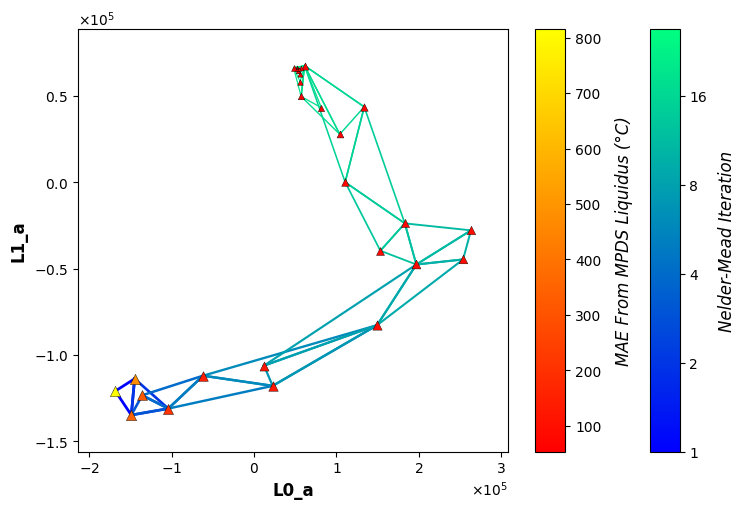

No arguments specified for 't_vals', setting 't_units' to 'K'


Ag: H_fusion = 11300.0 J/mol, T_fusion = 1234.93 K, T_vaporization = 2435.15 K
V: H_fusion = 21500.0 J/mol, T_fusion = 2183.0 K, T_vaporization = 3680.15 K

Reading MPDS json from entry at https://mpds.io/entry/C900067...

Best fitted parameters for Ag-V: [52618.11, -0.14, 1890.29, -0.57]
MAE = 21.78
L0 = 52618 - 0.14*t
L1 = 1890 - 0.57*t


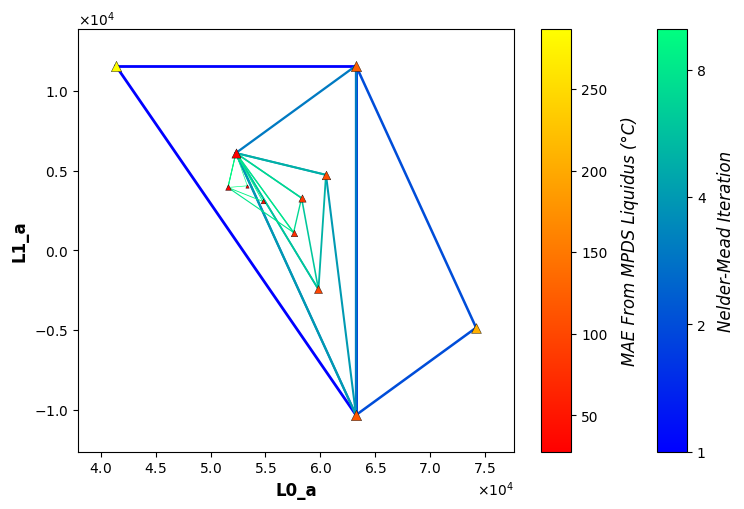

No arguments specified for 't_vals', setting 't_units' to 'K'


Al: H_fusion = 10710.0 J/mol, T_fusion = 933.5 K, T_vaporization = 2792.15 K
Cu: H_fusion = 13260.0 J/mol, T_fusion = 1357.77 K, T_vaporization = 2835.15 K

Reading MPDS json from entry at https://mpds.io/entry/C903362...

Best fitted parameters for Al-Cu: [-8335.5, -63.44, 78494.86, -107.59]
MAE = 22.23
L0 = -63.44*t - 8335
L1 = 78494 - 107.59*t


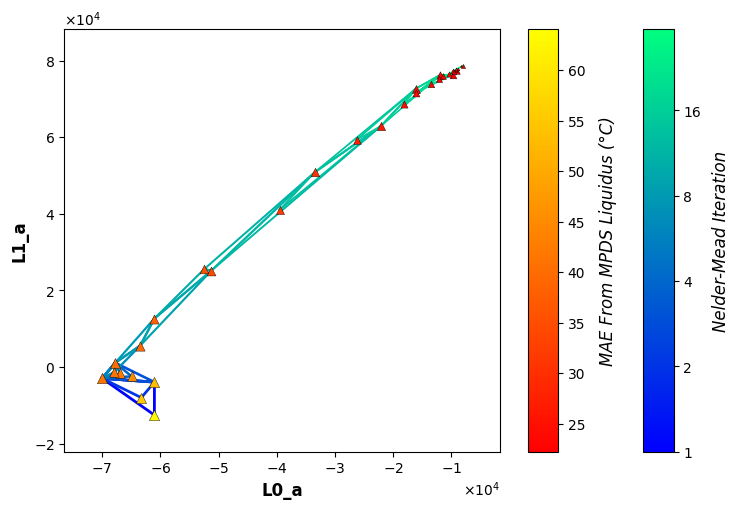

No arguments specified for 't_vals', setting 't_units' to 'K'


In [7]:
from gliquid.binary import a_sym, b_sym, c_sym, d_sym
import matplotlib.pyplot as plt

for sys_name, best_results in fitting_results.items():
    if not all(k in best_results for k in ['L0_a', 'L0_b', 'L1_a', 'L1_b']):
        continue
    bl = BinaryLiquid.from_cache(sys_name, param_format=param_format)
    bl.update_params((best_results['L0_a'], best_results['L0_b'], best_results['L1_a'], best_results['L1_b']))
    bl.nmpath = np.array(best_results.get('nmpath', []))
    print(f"Best fitted parameters for {sys_name}: {[float(f'{p:.2f}') for p in bl._params]}")
    print(f"MAE = {best_results['mae']:.2f}")
    print("L0 =", bl.eqs['l0'].subs({a_sym: int(bl.get_L0_a()), b_sym: round(bl.get_L0_b(), 2)}))
    print("L1 =", bl.eqs['l1'].subs({c_sym: int(bl.get_L1_a()), d_sym: round(bl.get_L1_b(), 2)}))
    blp = BLPlotter(bl)
    fig = blp.get_plot('nmp', plot_a_params=True) # If not specified or False, the default plot will show the Lb params
    plt.show() # Usually blp.show('nmp') works fine, but this is used to ensure the plot is displayed inline properly
    blp.show('fit+liq')
    blp.show('ch+g') # Specify specific temperatures for plotted liquid energy with t_vals and t_units arguments
  